# RSTT Tutorial 3
## Convergence of the Elo Rating System

This tutorial is based on the paper from Adrien Krifa, Florian Spinelli and Stéphane Junca [On the Convergence of the Elo rating system for a Bernoulli model](https://hal.science/hal-03286065/document)

The goal is to reproduce the simulation results of their work using python and the rstt package. The notebook follows the paper structure and focus on making bridges between the text and the package features.

This tutorials contains conding and reading exercises that assume you already have some experience with the rstt package (take a look at our previous tutorials). Code cells start with a comment label indicating its content.
- \# READ: code should be understood to continue coding.
- \# FEATURE: highligh an unusal rstt feature.
- \# TODO: will not run unless you fill the [...].
- \# PLOT: we use matplotlib to replicate figure styling. It may not be of your interest.
- \# EXAMPLE: serves as runable example for later \# TODO cells.

We use a simple data structure to store experimental results - a dictionary mapping experimental title to ranking status over time.
The utils module contains init/track_results functions and all plot cells are coded. You do not have to deal with this part of the research. You can **focus on coding the simulation model**. 

You can use dataframes for example, but you will need to adapt the entire notebook.

## 1. Introduction

RSTT provides a [BasicElo](https://rstt.readthedocs.io/en/latest/rstt.ranking.standard.html#module-rstt.ranking.standard.basicElo) ranking, using the [Elo](https://rstt.readthedocs.io/en/latest/rstt.ranking.inferer.html#module-rstt.ranking.inferer.elo) rating system.
You can verify that the implementation satisfies the model in the paper:

- (Eq. 1) & (Eq. 2) are implemented by the [Elo.update_rating](https://rstt.readthedocs.io/en/latest/rstt.ranking.inferer.html#rstt.ranking.inferer.elo.Elo.update_rating) method.
- (Eq. 3) K=20 is commonly used, thus the default value in the package.
- (Eq. 9) is implemented by the [Elo.expectedScore](https://rstt.readthedocs.io/en/latest/rstt.ranking.inferer.html#rstt.ranking.inferer.elo.Elo.expectedScore) method.

In [1]:
# FEATURE - Elo expected score

import matplotlib.pyplot as plt
from rstt import BasicElo

# an elo ranking
elo = BasicElo(name='Elo Tutorial', lc=400, k=20)

# illustrate the b function
x = list(range(-500, 500))
y = [elo.backend.expectedScore(rating1=1000, rating2=1000-diff) for diff in x]


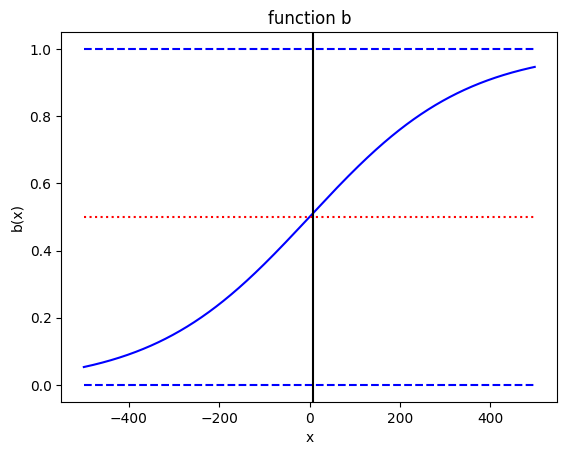

In [2]:
# PLOT

fig, ax = plt.subplots()
ax.plot(x, y, color='blue')
ax.plot(x, [1.0 for i in x], '--', color='blue')
ax.plot(x, [0.5 for i in x], ':', color='red')
ax.plot(x, [0.0 for i in x], '--', color='blue')
ax.axvline(x=7, color='black')
ax.set_xlabel('x')
ax.set_ylabel('b(x)')
plt.title('function b')
plt.show()

## 2. Two Player

In RSTT, any object providing a .name() and a .level() method are [SPlayer](), they can be register in Rankings, take part in Competition and play games. When the **strenght of player is constant** you can use either the [BasicPlayer]() or the [Player]() class. [Solver]() are an essential part of a simulation, responsible to assign a [Score]() to a [SMatch](). There are several different solvers available, but the one needed here is the [LogSolver](), which matches the Elo.expectedScore.

- **results of the matches are independant**
- **the expected result of an encounter depends only on the strenght difference**
- it uses the function b(x) = 1/(1+10^(-x/400)) where x is the difference in player levels.

Remark on the LogSolver: the base (by default 10) and the constant (by default 400) are tunable parameters.

In [3]:
# EXAMPLE

from rstt import BasicPlayer, Duel, LogSolver

# A standard for results
results = {}
title2 = "Elo Simulation, with p=b(rho1-rho2)"

# model
playerA, playerB = BasicPlayer('pA', 1500), BasicPlayer('pB', 700)
solver = LogSolver()

# parameters
depth = 1000

# initialization
elo.set_rating(key=playerA, rating=1000)
elo.set_rating(key=playerB, rating=1200)
results[title2] = {p: {'elo': [elo.rating(p)],
                       'rho': [p.level()]}
                   for p in [playerA, playerB]}

# simulation
for i in range(depth):
    # game generation
    duel = Duel(player1=playerA, player2=playerB) # LogSolver does not have an 'home/away' bias
    solver.solve(duel)

    # ranking update
    elo.update(game=duel)

    # results tracking
    results[title2][playerA]['elo'].append(elo.rating(playerA))
    results[title2][playerA]['rho'].append(playerA.level())
    results[title2][playerB]['elo'].append(elo.rating(playerB))
    results[title2][playerB]['rho'].append(playerB.level())


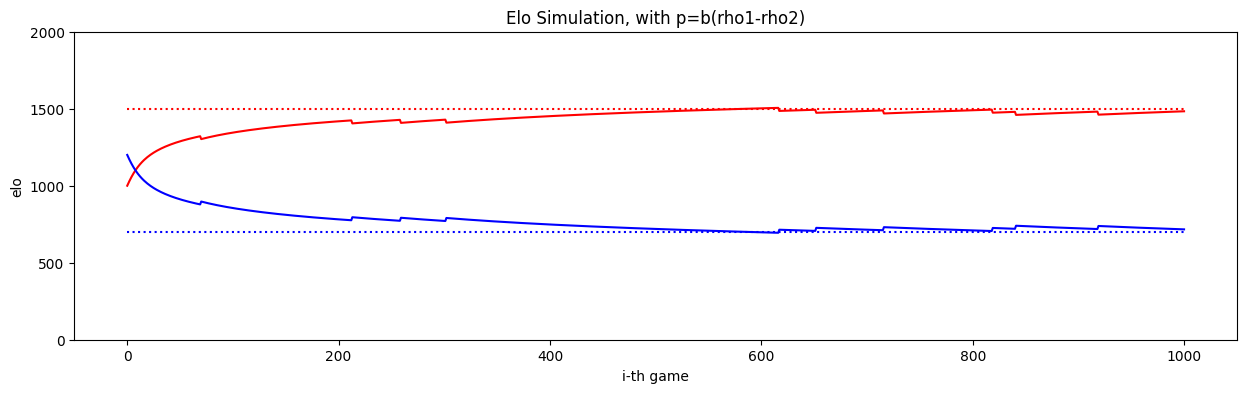

In [4]:
# PLOT
fig, ax = plt.subplots(figsize=(15, 4))
x = list(range(depth+1))

ax.plot(x, results[title2][playerA]['elo'], color='red')
ax.plot(x, results[title2][playerA]['rho'], ':', color='red')
ax.plot(x, results[title2][playerB]['elo'], color='blue')
ax.plot(x, results[title2][playerB]['rho'], ':', color='blue')

ax.set_xlabel('i-th game')
ax.set_xticks(list(range(0,1001,200)))
ax.set_ylabel('elo')
ax.set_yticks(list(range(0, 2001, 500)))

plt.title(title2)
plt.show()

#### Task

Redo the previous simulation with the rho difference between 2 players as a parameter

In [5]:
# TODO
from utils import init_results , track_results

# data tracking
title22 = "Elo Evolution with a rho differemce of {diff}"
results[title22] = {}

# model specification
mean_rho = 1000
diffs = [0, 400, 800, 1000]

# test ranking
elo22 = BasicElo('Elo Diff', default = mean_rho)

# simulation params
depth = 1000
solver = LogSolver()

# simulation
for diff in diffs:
    # generate players
    a, b = BasicPlayer('A', mean_rho+diff//2), BasicPlayer('B', mean_rho-diff//2)
    
    # add them to the elo system
    elo22.add([a,b])
    
    # initialize results report
    results[title22][diff] = init_results(pop=[a,b], ranking=elo22)

    # run
    for _ in range(depth):
        # generate game
        duel = Duel(a, b)

        # play game
        solver.solve(duel)
        
        # uodate elo
        elo22.update(game=duel)
        
        # track results
        track_results(pop=[a,b], ranking=elo22, results=results[title22][diff])

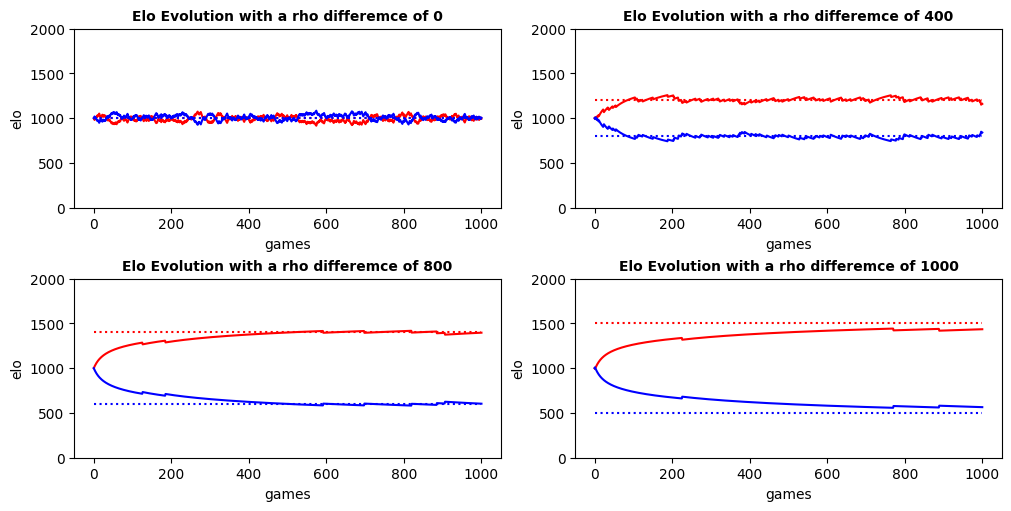

In [6]:
# PLOT
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(10, 5))
for (diff, data), ax in zip(results[title22].items(), axes.reshape(-1)):
    for player, color in zip(data.keys(), ['red', 'blue']):
        ax.plot(x, data[player]['elo'], color=color)
        ax.plot(x, data[player]['rho'], ':', color=color)

    ax.set_xlabel('games')
    ax.set_xticks([0, 200, 400, 600, 800, 1000])
    ax.set_ylabel('elo')
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_title(title22.format(diff=diff), fontsize=10, fontweight='bold')

plt.show()

## 3. N=3 players

In rstt, there is a strict distinction between:
- game generation or **Scheduler**: The package provides implementation of [Random Matchmaking](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.random.RandomRound) and [RoundRobin](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.groups.RoundRobin).
- outcome generation or **Solver**: with the [ScoreProb](https://rstt.readthedocs.io/en/latest/rstt.solver.html#rstt.solver.solvers.ScoreProb) the user can specify a probability for each potential score of an encounter.
- data preprocessing or **Observer**: a component used by a ranking to deal with the .update() method inputs. The package provides a [GamyByGame](https://rstt.readthedocs.io/en/latest/rstt.ranking.observer.html#rstt.ranking.observer.gameObserver.GameByGame) and a [BatchGame](https://rstt.readthedocs.io/en/latest/rstt.ranking.observer.html#rstt.ranking.observer.gameObserver.BatchGame) which are needed here.

First we need the solver. We implement a parametrizable 'matrix solver'.

In [7]:
# READ
from rstt.stypes import SPlayer
from rstt.solver.solvers import ScoreProb, WIN, LOSE

import random

# Simulation Model - Game Outcome Generator
class MatrixSolver(ScoreProb):
    def __init__(self, matrix: dict[SPlayer, dict[SPlayer, float]]):
        # matrix[p1][p2] := probabilitiy(p1 WIN against p2)
        self.matrix = matrix
        
        # restrict games outcome to win or lose. We do not have draw or partial wins.
        super().__init__(scores=[WIN, LOSE], func=self.expectedScore)

    def expectedScore(self, duel: Duel) -> list[float]:
        p1 = duel.player1()
        p2 = duel.player2()
        
        # return the probability of each potential game score i.e [WIN, LOSE]
        return [self.matrix[p1][p2], self.matrix[p2][p1]]

### Observer: updated after each tournament versus each game
(Eq. 35) is a en example of (Eq. 13) ratings computation for two games outcomes. The difference between 'updated after each tournament' and 'updated after each game' has to do with the function input and whether you apply:
- (Eq. 13) iteratively on each single game score, thus using effectively (Eq. 1).
- (Eq. 13) iteratively on each player with all its game results at once, hence (Eq. 35).

The handler attribute of a ranking is responsible to format the ranking.update input (referred to 'observations') and call the ranking.backend.rate method to produce new ratings. The BasicElo ranking class uses the GameByGame Observer as default handler, i.e correspond to 'update after each game'. The BatchGame calls the rate method with a player and its corresponding results in the input.

The case of the random matchmaking is not related with the handler of a ranking. It is an alternative to the RoundRobin scheduler. Since only one game is played per tournament, it does not matter if it uses the GameByGame or BatchGame observer.

In [8]:
# FEATURE - modify the handler attribute

from rstt.ranking import BatchGame

# Baseline
elo31 = BasicElo('randoms games system')

# update after each tournament - BatchGame
elo32 = BasicElo('RR tournaments (updated after each tournament ends)')
elo32.handler = BatchGame()

# update after each game - GameByGame
elo33 = BasicElo('RR tournaments (updated after each single match)')

### Game Data
The package offers a wide collection of popular game generation method, including RoundRobin. The RandomRound generates random games. The user can specify the number of rounds to play, and the number of games in each rounds. In our case we want one game per tournament edition, i.e one round of one game, which are the default parameters.

**Remark**:
Competition, like RoundRobin and RandomRound, needs a seeding parameter (a Ranking) which is used to decide which games are generated. 
In both our cases, the seeding will not have an effect on which game are created. However in the RoundRobin, the ordering of the game can be modified by the seedings which may affect the 'update after each single match' scenario.

The choice made in this tutorial is to set a strict experimental protocol that allows user to fine tune the exact simulation they want to perform.

#### Task

Read experiment() code. Make sure you understand the way data are produced and processed. Afterwards, feel free to make adjustement.

- Do you understand why the ordering of mathups within a tournament could be different from one edition to the other one ?

**YOUR ANSWER**: ...

- Do you see how to make it a constant ?

**YOUR ANSWER**: ...

In [9]:
# READ

from rstt.stypes import Solver
from rstt import Ranking, Competition

# let us also check package performance
import tqdm

def experiment(title: str, # title to track results
               rankings: list[Ranking], # a list of ranking to test
               solver: Solver, # a way to decide game score
               tournament: Competition, # a way to produce encounter
               depth: int # a number of tournament edition
              ) -> dict[str, dict[str, list[float]]]: # results

    # competition needs a seeder
    seeder = rankings[0]

    # track ratings
    results = {ranking.name: {player.name(): [ranking.rating(player)]
                              for player in seeder}
              for ranking in rankings
              }
    
    # simulation
    for i in tqdm.tqdm(range(depth)):
        # data production
        cup = tournament(name=f"{title} - {i}", seeding=seeder, solver=solver)
        cup.registration(seeder.players())
        cup.run()

        # update ratings
        for ranking in rankings:
            ranking.update(games=cup.games())

            # result tracking
            for player in seeder:
                results[ranking.name][player.name()].append(ranking.rating(player))

    return results

In [10]:
# EXAMPLE

from rstt import RoundRobin, RandomRound

# specification
title3 = "Elo Evolution  after {depth} {method}"

# simulation params
A, B, C = [BasicPlayer(name=name)for name in ['A', 'B', 'C']]
initial_ratings = {A: 1200, B: 1100, C: 1000 }
matrix = {A: {B: 2/3, C: 1/3}, B: {A: 1/3, C: 2/3}, C:{A: 2/3, B: 1/3}}
n3 = MatrixSolver(matrix)
depth = 400

# data tracking
results[title3] = {}

# initialisation
for ranking in [elo31, elo32, elo33]:
    for player, rating in initial_ratings.items():
        ranking.set_rating(player, rating)

# simulation
results[title3] = experiment(title3, [elo31], n3, RandomRound, depth)
results[title3].update(experiment(title3, [elo32, elo33], n3, RoundRobin, depth))

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 414.00it/s]


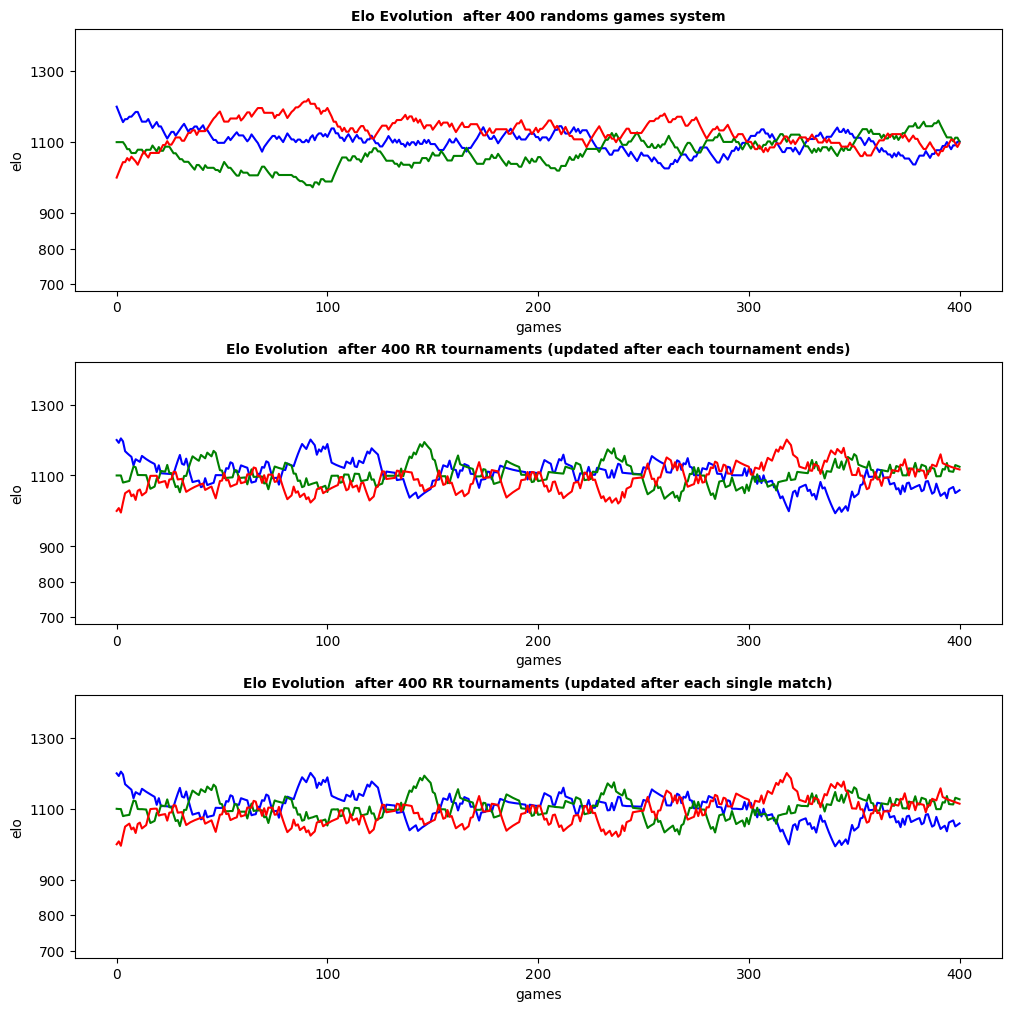

In [11]:
# PLOT

x = [i for i in range(depth+1)]
fig, axes = plt.subplots(3, constrained_layout=True, figsize=(10,10))
exp_res = results[title3].keys()
for ranking, ax in zip(exp_res, axes):
    ax.plot(x, results[title3][ranking]['A'], color='blue')
    ax.plot(x, results[title3][ranking]['B'], color='green')
    ax.plot(x, results[title3][ranking]['C'], color='red')

    ax.set_title(title3.format(depth=depth, method=ranking), fontsize=10, fontweight='bold')
    ax.set_xlabel('games')
    ax.set_xticks([0, 100, 200, 300, 400])
    ax.set_ylabel('elo')
    ax.set_yticks([700, 800, 900, 1100, 1300])
    ax.set_ylim(bottom=680, top=1420)

### Distinction between data/handler/backend
Consider the 'randoms games system' case.

An alternative coding would be to play one RandomRound of 400 rounds, each consisting in a single game.
- If you iterate over the games to update rankings: BatchGame and GameByGame are equivalent.
- If you use a GameByGame Observer it makes no difference to update by iterating on single game or pass the entire dataset at once.
- If you pass the entire dataset: GameByGame and BatchGame **are not** equivalent.

Another parametrization of the simulation, to compare ranking with equal amount of data, is to specify 3 games per random rounds. In this scenario, using an elo rating system with a GameByGame or a BatchGame handler are different.

**And the backend?**
Well the math behind rating inference is distinct from the data procedure. You could test a GlickoRating system with a GameByGame or BatchGame Observer on random games or round-robins aswell. Do you want to add it in a comparative study?

#### Task

- Redo the 'Elo evolution with randoms games system' but with 3 games per round.
- Compare an 'update after each tournaments' with 'update after each single game' using the same data set

In [12]:
# TODO 
import functools


# test ranking with an update by game approach
rmgbg = BasicElo('Random 3 Update by single game')
# test ranking with an update by tournament approach
rmbg = BasicElo('Random 3 Update by tournament')

# initialisation
for ranking in [rmgbg, rmbg]:
    for player, rating in initial_ratings.items():
        ranking.set_rating(player, rating)

# RandomRound with 3 games per round
MM3 = functools.partial(RandomRound, rounds=1, amount=3)

# run simulation
results[title3].update(experiment(title3, [rmgbg, rmbg], n3, MM3, depth))


100%|████████████████████████████████████████| 400/400 [00:00<00:00, 669.79it/s]


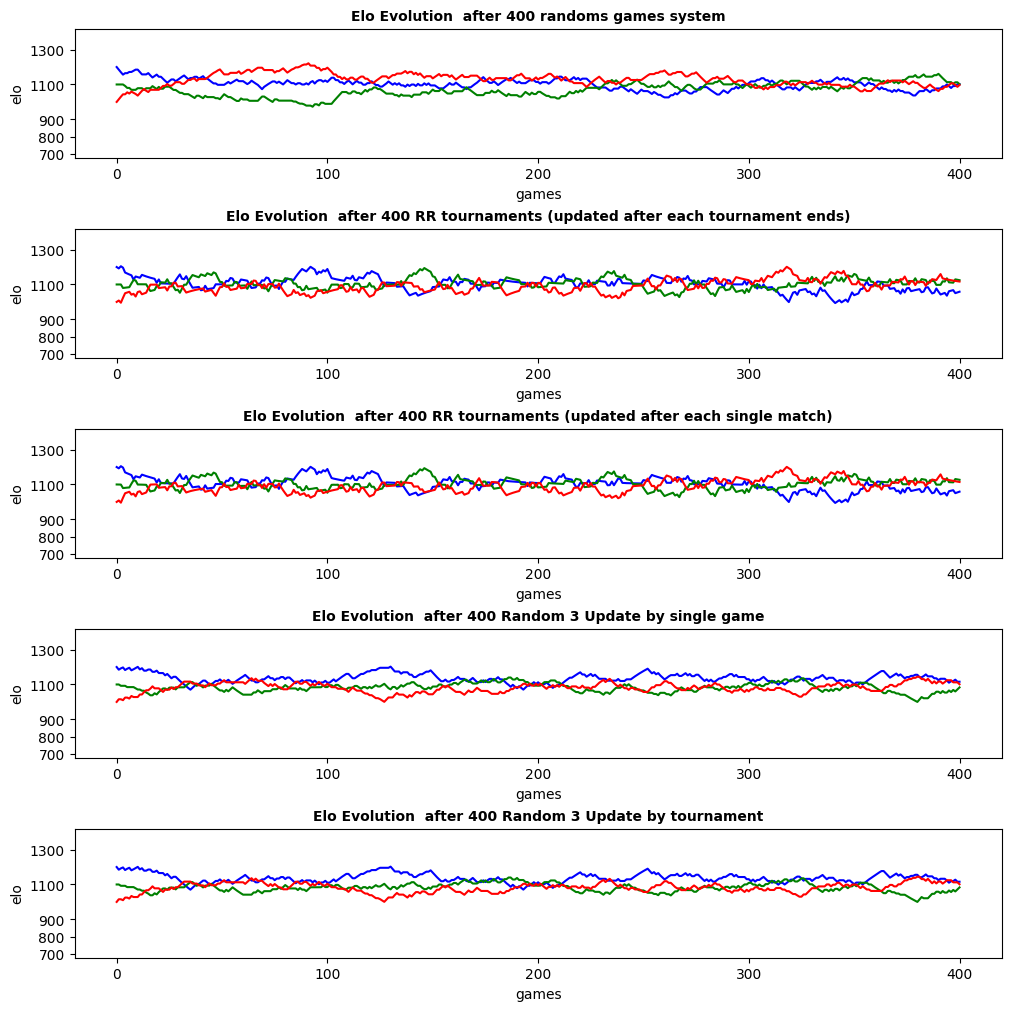

In [13]:
# PLOT
x = [i for i in range(depth+1)]
fig, axes = plt.subplots(len(results[title3].keys()), constrained_layout=True, figsize=(10,10))
exp_res = results[title3].keys()
for ranking, ax in zip(exp_res, axes):
    ax.plot(x, results[title3][ranking]['A'], color='blue')
    ax.plot(x, results[title3][ranking]['B'], color='green')
    ax.plot(x, results[title3][ranking]['C'], color='red')

    ax.set_title(title3.format(depth=depth, method=ranking), fontsize=10, fontweight='bold')
    ax.set_xlabel('games')
    ax.set_xticks([0, 100, 200, 300, 400])
    ax.set_ylabel('elo')
    ax.set_yticks([700, 800, 900, 1100, 1300])
    ax.set_ylim(bottom=680, top=1420)

## 4. Round-robin tournament for N >> 1

#### Task
At this stage you have learned everything needed to replicate both diagram about the ELO mean

In [14]:
# TODO / FEATURE - seeded_players

from statistics import mean

# experiment title
title4 = "Elo mean of 100 players in RRT {method}"

# create competitors
levels = list(range(600, 1600, 10))
population = BasicPlayer.seeded_players(nb=100, start=600, inc=10)

# test rankings
default = mean([p.level() for p in population])
elo41 = BasicElo('with update after each tournament', default=default, players=population)
elo41.handler = BatchGame()
elo42 = BasicElo('calcuated by natural probability', default=default, players=population)

# simulation run
depth = 400
results[title4] = experiment(title4, [elo41, elo42], LogSolver(), RoundRobin, depth)

100%|█████████████████████████████████████████| 400/400 [08:28<00:00,  1.27s/it]


### Ranking and Ground-Truth

Ranking is not just a system to process data and infer rating. It is a container of player offering an hybrid list/dict interface where the elements are automaticaly sorted based on their ratings.
Additionaly to standard ranking like Elo or Glicko, the package provides a [BTRanking](https://rstt.readthedocs.io/en/latest/rstt.ranking.standard.html#rstt.ranking.standard.consensus.BTRanking) which ranks player based on their levels. This means that for simulation using a LogSolver, it serves as the groundtruth.

This is convenient here as we want to plot the player's rating based on their strenght in the simulation. Take a look at how we sort players_rho and elos_means.

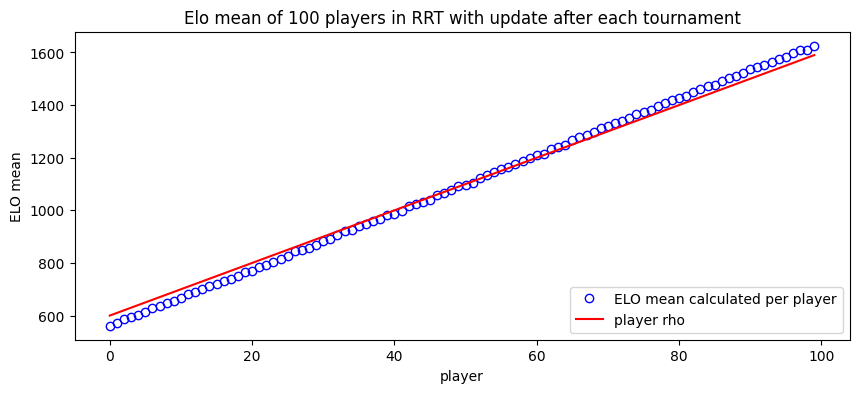

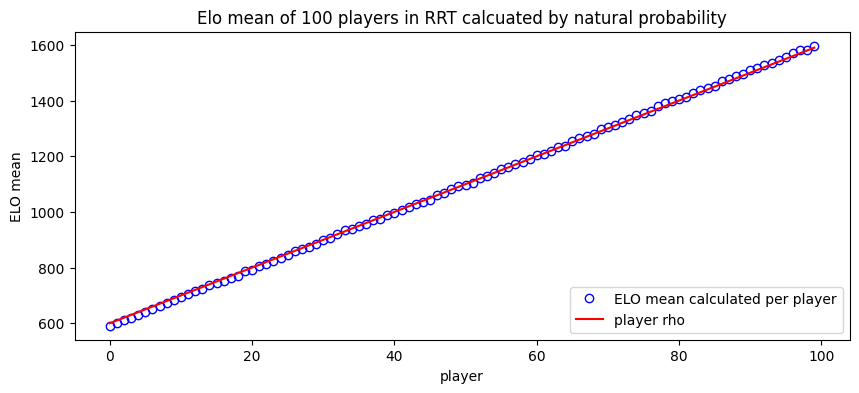

In [15]:
# PLOT / FEATURE - ranking slice are great for plot

from rstt import BTRanking
from statistics import mean


gt4 = BTRanking('Consensus', population)
for ranking in [elo41, elo42]:
    fig, ax = plt.subplots(figsize=(10,4))

    x =list(range(len(gt4)))

    # Here is a nice 'slicing ranking' feature.
    players_rho = [player.level() for player in gt4[::-1]] 
    elos_means = [mean(results[title4][ranking.name][player.name()]) for player in gt4[::-1]]

    ax.plot(x, elos_means, 'bo', markerfacecolor='none', label='ELO mean calculated per player')
    ax.plot(x, players_rho, color='red', label='player rho')

    ax.set_xlabel('player')
    ax.set_xticks([0,20,40,60, 80,100])
    ax.set_ylabel('ELO mean')
    ax.set_yticks([600, 800, 1000, 1200, 1400, 1600])

    plt.legend(loc='lower right')
    plt.title(title4.format(method=ranking.name))
    plt.show()

#### Task

Using the previous results and the Groundtruth ranking, select the correct player to reproduce the 'Elo Evolution and rho convergence for N players'

In [16]:
# TODO

# Which player to you want to see the elo convergence
target = gt4[::10]

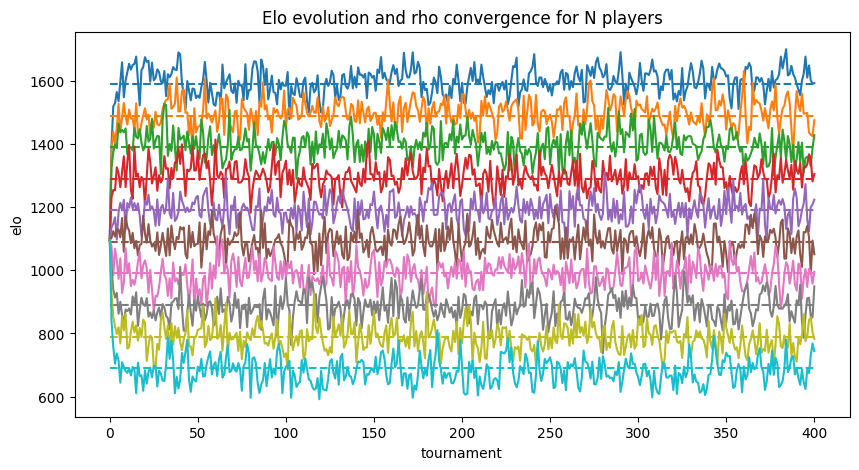

In [17]:
# PLOT

fig, ax = plt.subplots(figsize=(10,5))
x = list(range(depth+1))
for p in target:
    line, =plt.plot(x, results[title4][elo42.name][p.name()])
    dashed = plt.plot(x, [p.level() for i in x], '--', color=line.get_color())

ax.set_xlabel('tournament')
ax.set_ylabel('elo')
ax.set_title('Elo evolution and rho convergence for N players')

plt.show()

### Consensus Ranking Implementation

The notion of ranking in RSTT has some sort of formal definition, it consist of:
- A **standing**: an ordered list of (rank, player, points)
- A **datamodel**: a mapping Player -> Rating. It also providal an ordinal(Rating) -> float function
- A **backend**: A statistical inference system so to speak, a function that produce Rating
- A **handler**: We have already covered it, it is an input processor.

Implicitly a Ranking is also defined by its **Rating** object, and the **Observations** that justify an update and can be processed by the handler.

By Consensus Ranking we mean a Ranking that capture the simulation model strenght relationship between involved palyers. It is frequently convenient to have such one to compare infered results from a test ranking with **it should look like**.

If you are interested in how to build Ranking have a look at Tutorial 3 that show how to use a external package as a rating system, or Tutorial 4 that look into modeling.

In short, we build a Consensus ranking computing ratings with a Player object as input and output the sum of its win probabilities in a  MatrixSolver.

In [18]:
# READ

from rstt import Ranking
from rstt.ranking import KeyModel, PlayerChecker
from rstt.ranking.rating import GlickoRating
import statistics

class MatrixLevel():
    def __init__(self, solver: MatrixSolver):
        self.solver = solver 
        
    def rate(self, player: SPlayer) -> GlickoRating:
        probabilities = self.solver.matrix[player].values()
        return statistics.mean(probabilities)

class MatrixRanking(Ranking):
    def __init__(self, name: str, solver: MatrixSolver):
        backend = MatrixLevel(solver)
        super().__init__(name=name,
                         datamodel=KeyModel(default=0),
                         handler=PlayerChecker(),
                         backend=backend,
                         players=list(solver.matrix.keys()))

        self.update()
        
    def forward(self, *args, **kwargs):
        self.handler.handle_observations(players=self.players(), datamodel=self.datamodel, infer=self.backend)

#### Task

Redo the *Means of ELO for P free sorted by theorical power*
- Generate 200 players,
- Use the MatrixSolver with a unfirom probability matrix
- Use the MatrixRanking to sort player by power (for ploting)
- Use an Elo Ranking with a BatchGame Observer
- run the experiment

In [19]:
# TODO
import itertools

free_title = "Means of ELO for P free {consensus}"

# model
free_pop = BasicPlayer.create(nb=200)
free_matrix = {player: {} for player in free_pop}

for p1, p2 in itertools.combinations(free_pop, 2):
    free_matrix[p1][p2] = random.uniform(0.0, 1.0)
    free_matrix[p2][p1] = 1.0 - free_matrix[p1][p2]
free_solver = MatrixSolver(free_matrix)

# consensus ranking
free_gt = MatrixRanking(name='Sorted by theoretical Power', solver=free_solver)

# test ranking
free_elo = BasicElo('P free Elo', players=free_pop)
free_elo.handler = BatchGame()

# simulation
depth = 500
results[free_title] = experiment(free_title, [free_elo], free_solver, RoundRobin, depth)

100%|█████████████████████████████████████████| 500/500 [32:00<00:00,  3.84s/it]


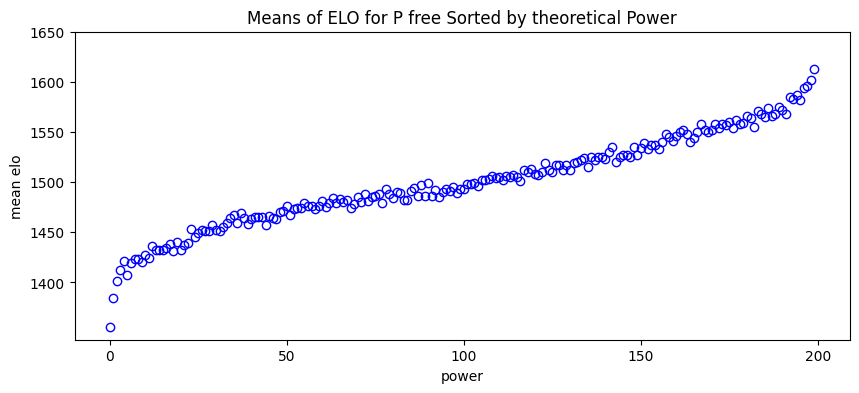

In [20]:
# PLOT

fig, ax = plt.subplots(figsize=(10, 4))

powers = list(range(0, len(free_gt)))
elos_mean = [mean(results[free_title][free_elo.name][p.name()]) for p in free_gt[::-1]]
ax.plot(powers, elos_mean, 'bo', markerfacecolor='none', label='ELO mean calculated per player')

ax.set_xlabel('power')
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_ylabel('mean elo')
ax.set_yticks([1400, 1450, 1500, 1550, 1600, 1650])

plt.title(free_title.format(consensus=free_gt.name))
plt.show()

## 5. Research Extention

Congratulation, you conducted your first simulation in RSTT. However, you have not seen experienced the greatest assets of the package.
RSTT excells by its modularity that enables comparative studies and quick changes in model specification.
You are now invited to make little changes to the code by modify some of the simulation parameters. 

- Change the population, try **Time Varing Strenght player**, use .update_level() to modify their strenght and .level() method to track *rho* values or a Consensus ranking.
- Change BasicElo to **BasicGlicko** and track ranking.point(player) instead of .rating().
- Try **SwissRound** instead of RoundRobin.
- Explore other metric like rank correlation between consensus and test ranking, or the maximal rank difference of players over time. 

#### Task
- Change the population, try **Time Varing Strenght player**, use .update_level() to modify their strenght and .level() method to track *rho* values or a Consensus ranking.
- Change BasicElo to **BasicGlicko** and track ranking.point(player) instead of .rating().
- Try **SwissRound** instead of RoundRobin.
- Explore other metric like rank correlation between consensus and test ranking, or the maximal rank difference of players over time. 

In [21]:
# TODO: Have Fun!